In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd

import dask
import dask.array as da
from dask import delayed

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patheffects as PathEffects
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage.measurements import center_of_mass

from glob import glob

from datetime import datetime, timedelta

import scipy.stats as stats

from flox.xarray import xarray_reduce

/var/tmp/pbs.1882978.polaris-pbs-01.hsn.cm.polaris.alcf.anl.gov/ipykernel_777787/1323040687.py:17: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
shear = pd.read_pickle('../data/SHEAR_0to6KMAGL.pkl')

mucape = pd.read_pickle('../data/AFWA_CAPE_MU.pkl')

In [3]:
shear_bins=np.arange(0,52,2)
cape_bins=np.arange(0,1040,40)

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors in the order you mentioned
colors = [
    (1.0, 1.0, 1.0),   # white
    (0.6, 0.8, 1.0),   # light blue
    (0.0, 0.2, 0.6),   # dark blue
    (0.0, 0.6, 0.0),   # green
    (1.0, 1.0, 0.0),   # yellow
    (1.0, 0.65, 0.0),  # orange
    (1.0, 0.0, 0.0),   # red
    (0.5, 0.0, 0.0)    # dark red
]

# Create a colormap using LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256).resampled(20)


new_colors=plt.get_cmap('coolwarm')(np.linspace(0,1,256))
new_colors[100:160]=[1,1,1,1]

seis_cmap=mcolors.ListedColormap(new_colors).resampled(12)
seis_cmap

mean_state_cmap=\
(custom_cmap).resampled(12)

diff_state_cmap=plt.get_cmap('coolwarm').resampled(16)

In [5]:
list(mucape.keys())

['historicalForcedALLSoutheast',
 'historicalForcedJJASoutheast',
 'historicalForcedMAMSoutheast',
 'historicalForcedSONSoutheast',
 'historicalForcedALLNortheast',
 'historicalForcedJJANortheast',
 'historicalForcedMAMNortheast',
 'historicalForcedSONNortheast',
 'historicalForcedALLSouthern Plains',
 'historicalForcedJJASouthern Plains',
 'historicalForcedMAMSouthern Plains',
 'historicalForcedSONSouthern Plains',
 'historicalForcedALLMidwest',
 'historicalForcedJJAMidwest',
 'historicalForcedMAMMidwest',
 'historicalForcedSONMidwest',
 'historicalForcedALLNorthern Plains',
 'historicalForcedJJANorthern Plains',
 'historicalForcedMAMNorthern Plains',
 'historicalForcedSONNorthern Plains',
 'historicalForcedALLECONUS',
 'historicalForcedJJAECONUS',
 'historicalForcedMAMECONUS',
 'historicalForcedSONECONUS',
 'historicalUnforcedALLSoutheast',
 'historicalUnforcedJJASoutheast',
 'historicalUnforcedMAMSoutheast',
 'historicalUnforcedSONSoutheast',
 'historicalUnforcedALLNortheast',
 'his

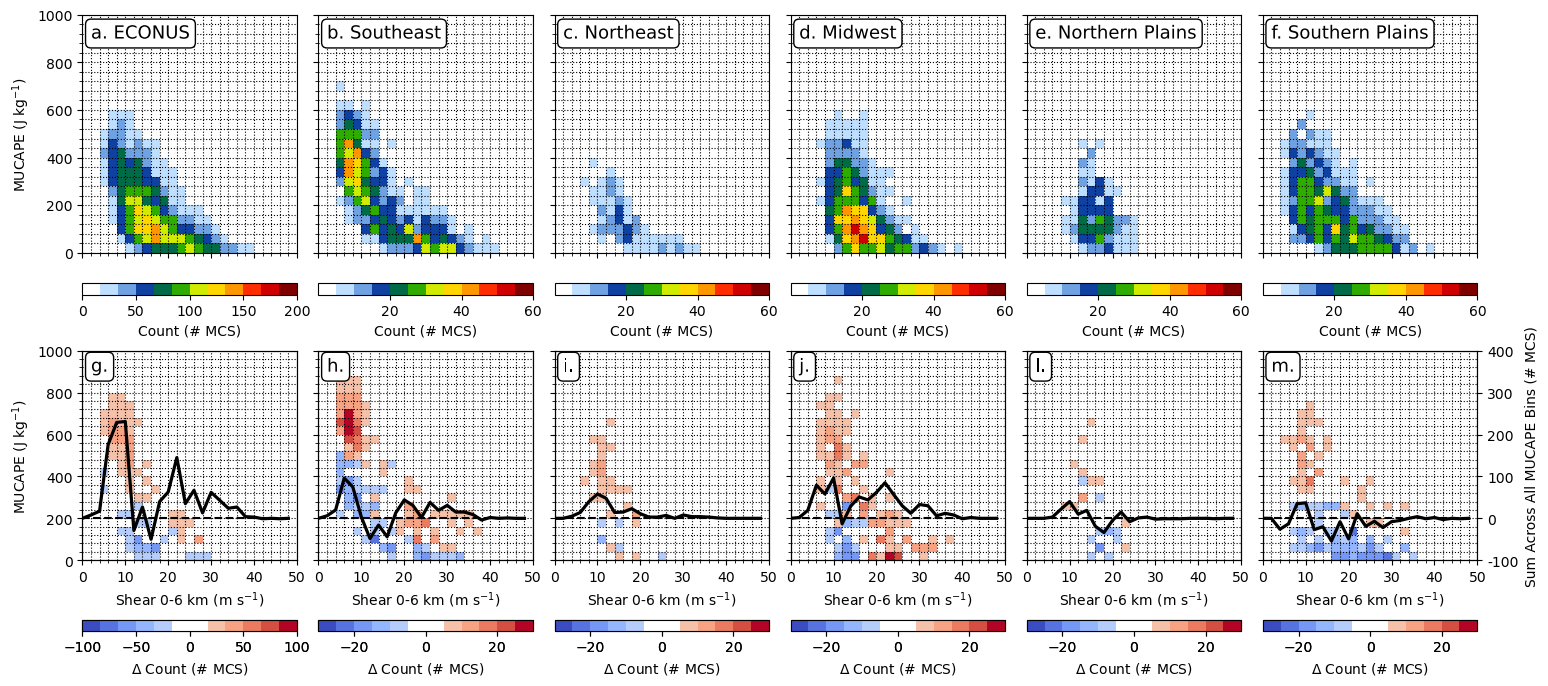

In [6]:
#you have to draw the colorbar twice with the dual axes thing. it's weird but it works so whatever

season_order = ['ALL', 'DJF', 'MAM', 'JJA', 'SON']
region_order = ['ECONUS', 'Southeast', 'Northeast', 'Midwest', 'Northern Plains', 'Southern Plains']
letters=['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.', 'l.', 'm.', 'n.', 'p.',]

fig, axs = plt.subplots(2, 6)

fig.set_figheight(8)
fig.set_figwidth(18)

b = 0

for i in range(2):
    for j in range(6):
        ax = axs[i,j]

        
        #s = season_order[i%5]
        s='ALL'
        f='All'
        r = region_order[j%6]

        if i==0:
            vmesh = xarray_reduce(
                    mucape['historical'+f+s+r],
                    mucape['historical'+f+s+r],
                    shear['historical'+f+s+r],
                    func='count',
                    expected_groups=(
                        pd.IntervalIndex.from_breaks(cape_bins),
                        pd.IntervalIndex.from_breaks(shear_bins),
                    ))
    
            if s=='ALL' and r=='ECONUS':
                c = ax.pcolormesh(vmesh, cmap=mean_state_cmap, vmin=0, vmax=200)
            elif r=='ECONUS':
                c = ax.pcolormesh(vmesh, cmap=mean_state_cmap, vmin=0, vmax=60)
            else:
                c = ax.pcolormesh(vmesh, cmap=mean_state_cmap, vmin=0, vmax=60)
        else:
            vmesh_hist = xarray_reduce(
                        mucape['historical'+f+s+r],
                        mucape['historical'+f+s+r],
                        shear['historical'+f+s+r],
                        func='count',
                        expected_groups=(
                            pd.IntervalIndex.from_breaks(cape_bins),
                            pd.IntervalIndex.from_breaks(shear_bins),
                        ))

            vmesh_eoc = xarray_reduce(
                        mucape['end_of_century_8p5'+f+s+r],
                        mucape['end_of_century_8p5'+f+s+r],
                        shear['end_of_century_8p5'+f+s+r],
                        func='count',
                        expected_groups=(
                            pd.IntervalIndex.from_breaks(cape_bins),
                            pd.IntervalIndex.from_breaks(shear_bins),
                        ))

        
            if s=='ALL' and r=='ECONUS':
                c = ax.pcolormesh(vmesh_eoc - vmesh_hist, cmap=seis_cmap, vmin=-100, vmax=100)
            elif r=='ECONUS':
                c = ax.pcolormesh(vmesh_eoc - vmesh_hist, cmap=seis_cmap, vmin=-50, vmax=50)
            else:
                c = ax.pcolormesh(vmesh_eoc - vmesh_hist, cmap=seis_cmap, vmin=-30, vmax=30)


        if i==1:
            ax.set_xlabel('Shear 0-6 km (m s$^{-1}$)')
        if j==0:
            ax.set_ylabel('MUCAPE (J kg$^{-1}$)')

        ax.grid(True, color='k', linestyle=':', which='both')  # Show both major and minor grids

        divider = make_axes_locatable(ax)

        if i==0:
            cpad = 0.3
        else:
            cpad = 0.6
        
        cax = divider.append_axes("bottom", size="5%", pad=cpad)  # Adjust size and padding as needed
        
        cbar = plt.colorbar(c, cax=cax, orientation='horizontal')

        if i==0 and j>0:
            cbar.set_ticks([20,40,60])
        
        if i==0:
            cbar.set_label('Count (# MCS)')
        else:
            cbar.set_label('$\Delta$ Count (# MCS)')


        if i==0:
            t=ax.text(0.04,0.9,letters[b]+' '+r,
                      horizontalalignment='left',
                      size=13,color='k',
                      path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                      transform=ax.transAxes)
        else:
            t=ax.text(0.04,0.9,letters[b],
                          horizontalalignment='left',
                          size=13,color='k',
                          path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                          transform=ax.transAxes)

        t.set_bbox(dict(boxstyle='round',facecolor='white',alpha=1,edgecolor='black'))
            
            
        if i==1:
            ax2=ax.twinx()
            ax2.plot(range(25),(vmesh_eoc - vmesh_hist).sum('AFWA_CAPE_MU_bins'), color='k', linewidth=2.3)
            ax2.plot(range(25),[0]*25, color='k', linestyle='--')
            ax2.set_yticks([])
            ax2.set_xticks([])
            ax2.set_ylim(-100,400)
            
            if j==5:
                ax2.set_yticks([-100,0,100,200,300,400], labels=[-100,0,100,200,300,400])
                ax2.set_ylabel('Sum Across All MUCAPE Bins (# MCS)')

            divider = make_axes_locatable(ax2)

            if i==0:
                cpad = 0.3
            else:
                cpad = 0.6

            cax = divider.append_axes("bottom", size="5%", pad=cpad)  # Adjust size and padding as needed

            cbar = plt.colorbar(c, cax=cax, orientation='horizontal')

        ax.set_xticks(np.arange(0, 26, 1), minor=True)
        ax.set_yticks(np.arange(0, 26, 1), minor=True)

        if j==0:
            ax.set_yticks(np.arange(0,30,5), labels=cape_bins[::5])
        else:
            ax.set_yticks(np.arange(0,30,5), labels=[])

        if i==0:
            ax.set_xticks(np.arange(0,30,5), labels=[])
        else:
            ax.set_xticks(np.arange(0,30,5), labels=shear_bins[::5])

        b+=1
        
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()
plt.close()